In [39]:
using KernelDensityEstimate
using Gadfly
using Distributions, StatsBase
using IteratedProbabilisticClassification
# don't mind syntax warnings, these are being removed from package dependencies over time

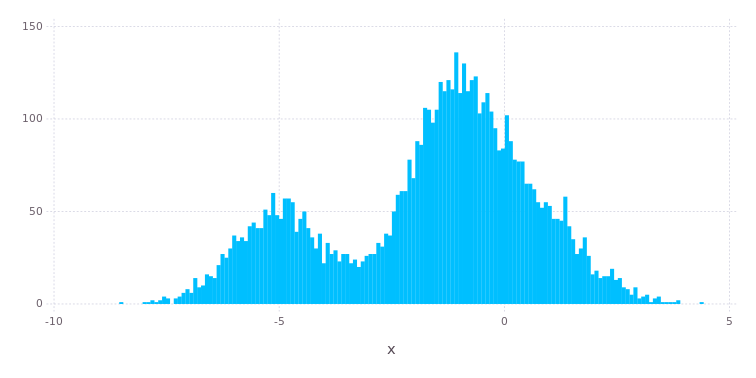

In [3]:
# modified EM classification algorithm has these major tuning parameter 
params = TuningParameters(
Mfair=200,   # Cluster distribution approximation accuracy, more is better: 50 is bare minium, and computation slow above ~1000
EMiters=40  # expectation maximization iterations to refine Cluster belief estimate classification assignments: 5 is minimum, and diminishing returns beyond ~70
)

# Example: simulated data with ground truth for reference
N1, N2 = 5000, 1000
data, groundtruth = simdata01_true(N1=N1,N2=N2)

# actual distribution of data
Gadfly.set_default_plot_size(20cm, 10cm)
plot(x=data.samples, Geom.histogram)

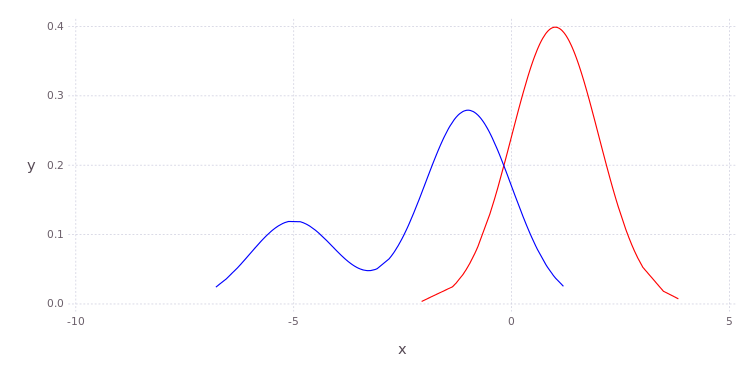

In [4]:
# Ground truth distribution of underlying data clusters
Gadfly.set_default_plot_size(20cm, 10cm)
# a generic 1D plotting tool for IteratedProbablisticClassification 
plotUtil1D(groundtruth=groundtruth)

In [30]:
# belief from expert prediction, also used for initialization
c1_expert = kde!(3.5*randn(params.Mfair)-2.0); # Pretty much a normal distribution
c2_expert = kde!(2.0*randn(params.Mfair)+5.0); # Pretty much a normal distribution

# cs is the main structure which classification algorithm will operate on, and modify during execution
cs = ClassificationSystem(
2,                              # number of categories or classes available for assignment
Dict(1=>"class1", 2=>"class2"), # names of classes
Dict(1=>"blue", 2=>"red"),      # default plotting colors
Dict(1=>c1_expert, 2=>c2_expert), # user forcing behaviour (expert guidance); required
Dict(1=>deepcopy(c1_expert), 2=>deepcopy(c2_expert)), # initialize temporal prediction (forward-backward smoothing)
Dict(1=>deepcopy(c1_expert), 2=>deepcopy(c2_expert)), # initialize current belief (0 iterations)
rand(Categorical([0.5;0.5]),length(data.samples)) # initialize samples with random assignment, 50/50% in this 2 class case
);
println()

In [31]:
# expert may modify expertBelief using output from previous run of classification algorithm
# cs.expertBelief[1] = deepcopy(stats.ESTBELIEF[1][end]);
# cs.expertBelief[2] = deepcopy(stats.ESTBELIEF[2][end]);
# println()

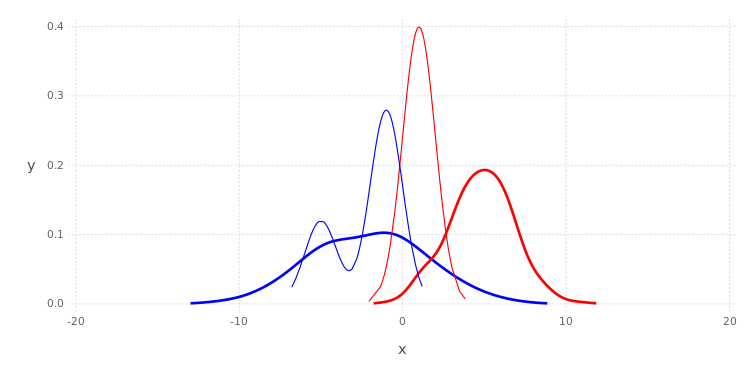

In [32]:
Gadfly.set_default_plot_size(20cm, 10cm)
# plotUtil1D(cs=cs) # if we didn't have gt
plotUtil1D(groundtruth=groundtruth, cs=cs)

In [33]:
# simulation data allows us to debug with absolute knowledge
dbg = defaultDebugResults()

# do the classification
stats = EMClassificationRun!(params, cs, data, debug=dbg, groundtruth=groundtruth);
println()

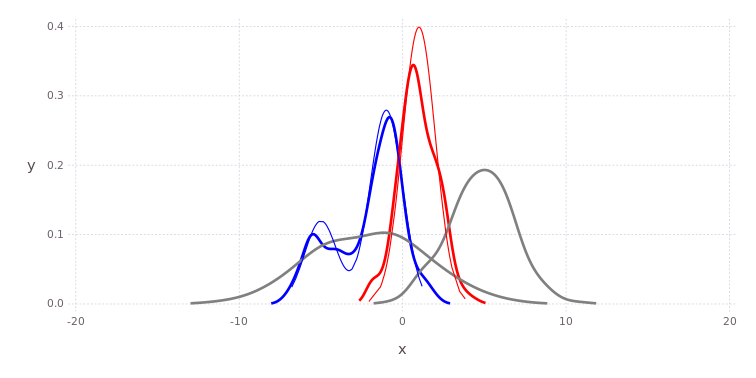

In [34]:
Gadfly.set_default_plot_size(20cm, 10cm)
plotUtil1D(cs=cs, groundtruth=groundtruth, 
  drawcurrent=true, 
  expertcolor=Dict(1=>"gray",2=>"gray")
)

In [35]:
sum(cs.assignment .== 1), sum(cs.assignment .== 2)

(4963,1037)

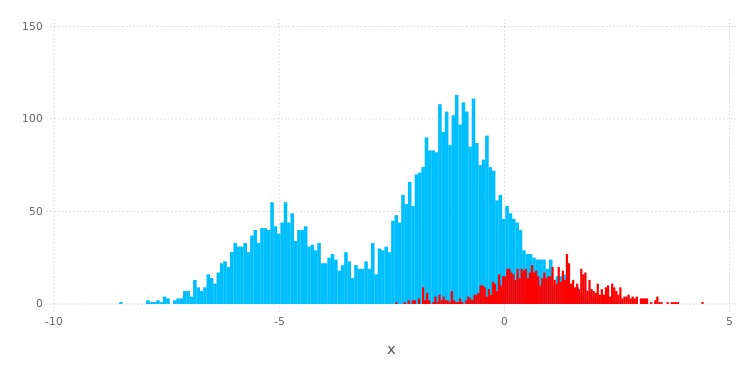

In [36]:
Gadfly.set_default_plot_size(20cm, 10cm)
plot(
layer(x=data.samples[1,cs.assignment .== 2], Geom.histogram,Theme(default_color=colorant"red")),
layer(x=data.samples[1,cs.assignment .== 1], Geom.histogram)
)

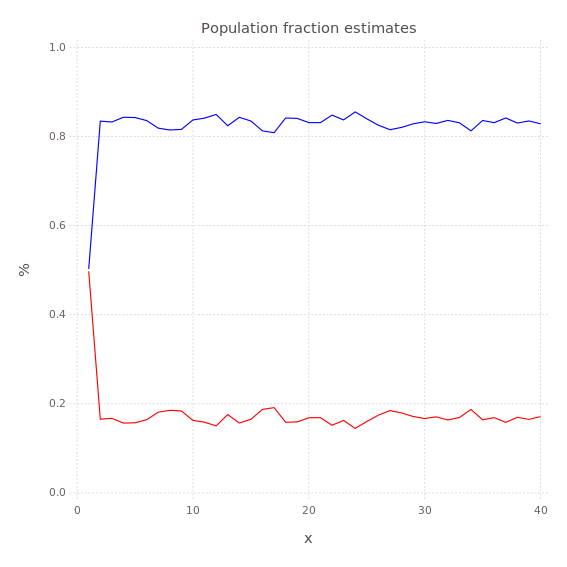

In [37]:
# proxy to convergence of classification algorithm, always available from stats structure
Gadfly.set_default_plot_size(15cm, 15cm)
plotPopulationFraction(params,stats)

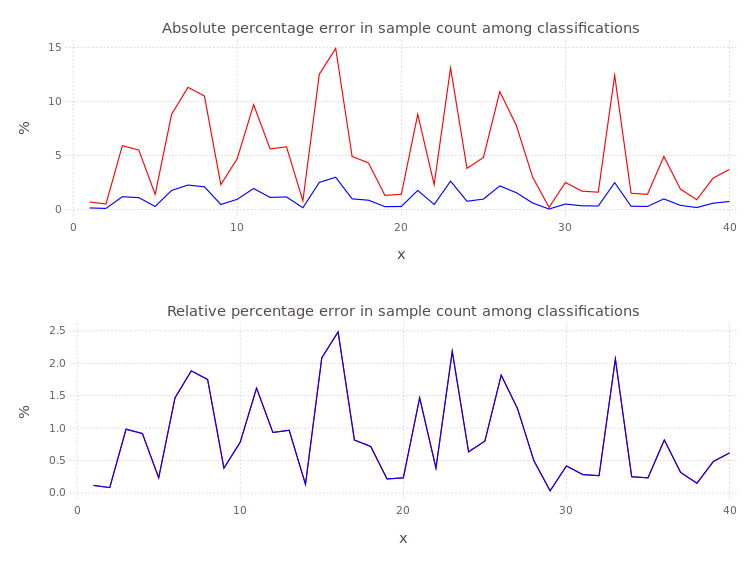

In [38]:
# only available when ground truth data is available
Gadfly.set_default_plot_size(20cm, 15cm)
plotClassificationStats(params, dbg)